In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Laplace
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
# 시그모이드 함수 (r(z))
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

In [3]:
# 간단한 선형 모델 정의
class SimpleModel(nn.Module):
    def __init__(self, input_dim):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 36)
        self.fc2 = nn.Linear(36, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x.squeeze()

In [4]:
import torch
import random
import torch.backends.cudnn as cudnn
import numpy as np

seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(seed)

In [5]:
def generate_ica_data(batch_size, input_dim):
    A = torch.randn(input_dim, input_dim)
    laplace_dist = Laplace(torch.zeros(input_dim), torch.ones(input_dim))
    s = laplace_dist.sample((batch_size,))
    data = s @ A.T
    return data

def compute_log_noise_probs(samples, mean=0.0, std=1.0):
    var = std ** 2
    log_probs = -0.5 * (torch.log(torch.tensor(2 * torch.pi * var)) + (samples - mean)**2 / var)
    return log_probs.sum(dim=1)

In [19]:
input_dim = 4
batch_size = 1000

A = torch.randn(input_dim, input_dim)
laplace_dist = Laplace(torch.zeros(input_dim), torch.ones(input_dim))
s = laplace_dist.sample((batch_size,))

In [6]:
data_size = 1000
input_dim = 4
num_epochs = 40
learning_rate = 0.005

train_data_samples = generate_ica_data(data_size, input_dim)
test_data_samples = generate_ica_data(data_size, input_dim)

noise_samples = torch.randn(batch_size, input_dim)
log_noise_probs = compute_log_noise_probs(torch.cat([train_data_samples, noise_samples]))

model = SimpleModel(input_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Text(0.5, 1.0, 'Log prob for Noise distribution at [train data/noise sample]')

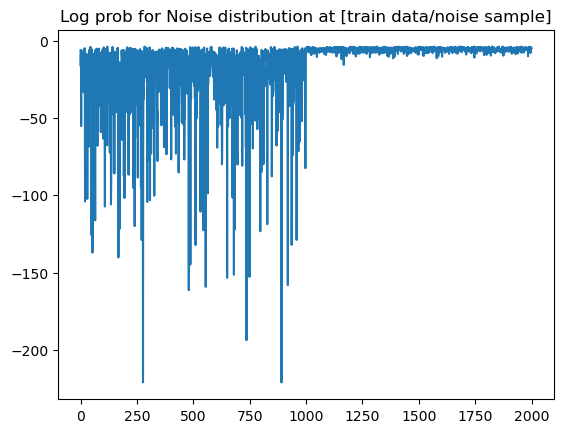

In [16]:
plt.plot(log_noise_probs)
plt.title("Log prob for Noise distribution at [train data/noise sample]")

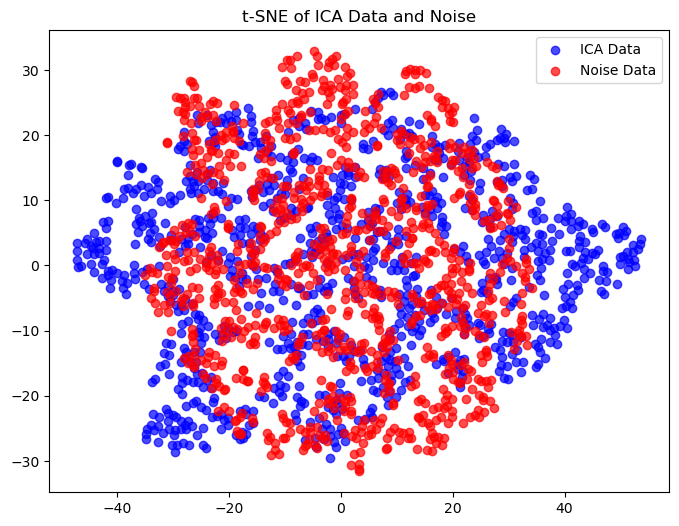

In [8]:
from sklearn.manifold import TSNE

# TSNE 차원 축소 (4차원 -> 2차원)
tsne = TSNE(n_components=2)
data_2d_tsne = tsne.fit_transform(train_data_samples.numpy())  # ICA 데이터
noise_2d_tsne = tsne.fit_transform(noise_samples.numpy())  # 잡음 데이터

# 시각화
plt.figure(figsize=(8, 6))
plt.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c='blue', label='ICA Data', alpha=0.7)
plt.scatter(noise_2d_tsne[:, 0], noise_2d_tsne[:, 1], c='red', label='Noise Data', alpha=0.7)
plt.title('t-SNE of ICA Data and Noise')
plt.legend()
plt.show()

In [9]:
# NCE 목적 함수
def nce_loss(f_x, f_y, log_noise_probs):
    term1 = torch.log(sigmoid(f_x - log_noise_probs[:len(f_x)])).mean()
    term2 = torch.log(1 - sigmoid(f_y - log_noise_probs[len(f_x):])).mean()
    loss = -0.5 * (term1 + term2)
    return loss

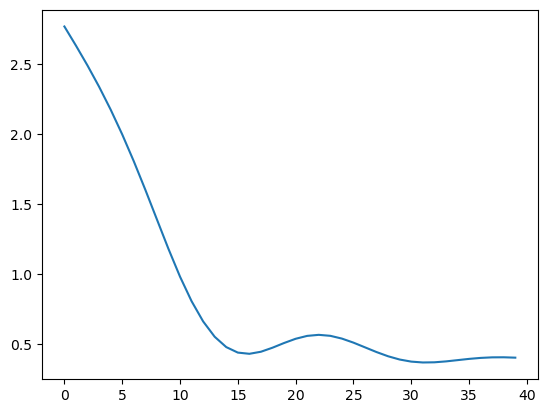

In [10]:
loss_list = []

# 학습 루프
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward
    f_x = model(train_data_samples)
    f_y = model(noise_samples)

    # NCE 손실 계산
    loss = nce_loss(f_x, f_y, log_noise_probs)

    # 역전파 및 매개변수 업데이트
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())

plt.plot(loss_list)

Test Loss: 0.4328


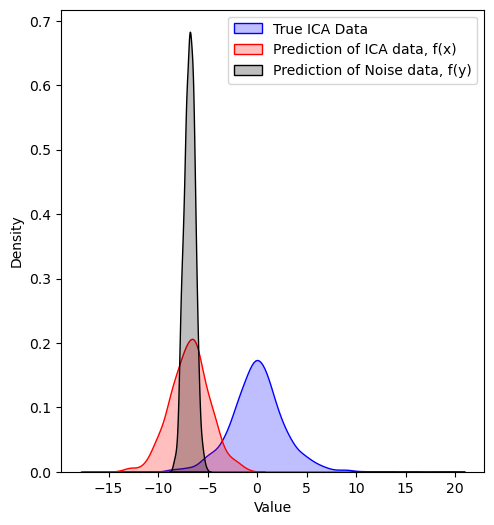

In [11]:
# 모델 테스트
model.eval()  # 평가 모드로 설정

# 테스트 데이터에 대한 예측
with torch.no_grad():
    f_test_x = model(test_data_samples)
    f_test_y = model(noise_samples)

    # NCE 손실 계산 (테스트용)
    test_log_noise_probs = compute_log_noise_probs(torch.cat([test_data_samples, noise_samples]))
    test_loss = nce_loss(f_test_x, f_test_y, test_log_noise_probs)

# 테스트 손실 출력
print(f"Test Loss: {test_loss.item():.4f}")

# 예측 결과 시각화 (테스트 데이터와 예측값 비교)
plt.figure(figsize=(12, 6))

# KDE 시각화
plt.subplot(1, 2, 1)
sns.kdeplot(test_data_samples.numpy().flatten(), label="True ICA Data", color='blue', fill=True)
sns.kdeplot(f_test_x.numpy().flatten(), label="Prediction of ICA data, f(x)", color='red', fill=True)
sns.kdeplot(f_test_y.numpy().flatten(), label="Prediction of Noise data, f(y)", color='black', fill=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

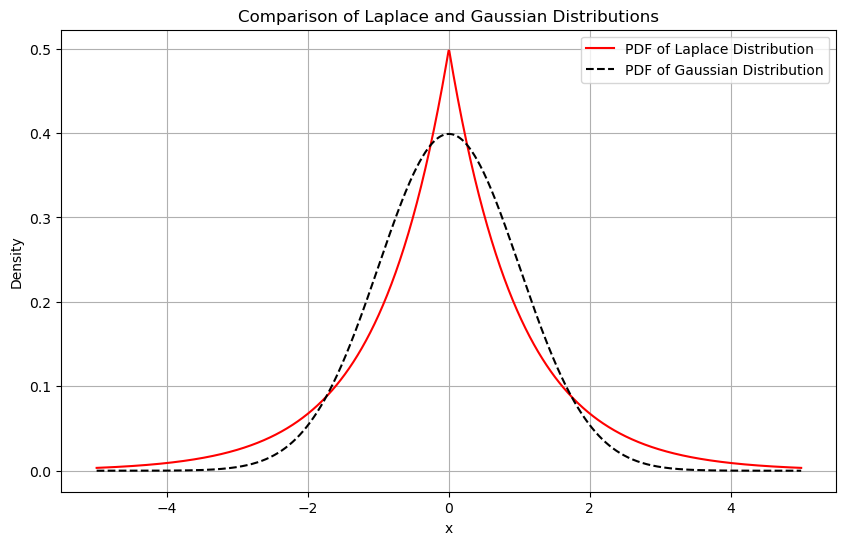

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 라플라스 및 가우시안 분포 시각화 함수
def plot_laplace_and_gaussian(mu=0, b=1, sigma=1, num_samples=10000):
    # 라플라스 분포 샘플링
    laplace_samples = np.random.laplace(mu, b, num_samples)
    
    # 가우시안 분포 샘플링
    gaussian_samples = np.random.normal(mu, sigma, num_samples)

    # 시각화
    plt.figure(figsize=(10, 6))

    # 라플라스 분포 PDF
    x = np.linspace(mu - 5 * b, mu + 5 * b, 1000)
    laplace_pdf = (1 / (2 * b)) * np.exp(-np.abs(x - mu) / b)
    plt.plot(x, laplace_pdf, 'r-', label='PDF of Laplace Distribution')

    # 가우시안 분포 PDF
    gaussian_pdf = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    plt.plot(x, gaussian_pdf, 'k--', label='PDF of Gaussian Distribution')

    # 플롯 설정
    plt.title('Comparison of Laplace and Gaussian Distributions')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# 분포 시각화 함수 호출
plot_laplace_and_gaussian()
